## Notebook: Generating SLSN Light Curves based on ZTF Raw Data

This notebook shows how to: <br />
1) Load raw ZTF data into the `simsurvey` <br />
2) Feed the SLSN lightcurves generated using the `Magnetar Model` to the transient generator <br />
3) Generate the simulated SLSN light curves which can be detected by the ZTF Survey. <br />
4) Filters the simulated light curves with cutoffs like `|b| > 10` and `sum(rmag < 19.5) >= 3`  <br />
5) Plots the detection phase distribution and the redshift distribution of the SLSNe


In [1]:
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxx-----------------Generating SLSN Light Curves----------------------xxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #

# ------------------------------------------------------------------------------------------------------------------- #
# Import Modules
# ------------------------------------------------------------------------------------------------------------------- #
import os
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator

import sncosmo
import simsurvey
from astropy.time import Time
from astropy import units as u
from astropy.cosmology import Planck15
from astropy.coordinates import SkyCoord
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Initialize Globals
# ------------------------------------------------------------------------------------------------------------------- #
gallat_cutoff = 10
mag_band = 'ztfr'
mag_cutoff = 19.5
npoints = 4

time_start = time.time()
cm = cm.get_cmap('jet')
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Initialize Directories
# ------------------------------------------------------------------------------------------------------------------- #
os.environ["HOME"] = "/data/asingh/simsurvey"
DIR_HOME = os.environ.get("HOME")

# Directory containing the data files
DIR_DATA = "/data/cfremling/simsurvey"
# Directory containing the dust map files of Schlegel, Finkbeiner & Davis (1998)
DIR_SFD = os.path.join(DIR_HOME, "data/sfd98")

# Enter the name of the 'ztf_sim' output file you would like to use.
survey_file = os.path.join(DIR_DATA, "notebooks/df_sim_stats_full.p")
survey_fields = os.path.join(DIR_HOME, "data/ZTF_Fields.txt")
survey_ccds = os.path.join(DIR_HOME, "data/ZTF_corners.txt")
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Load ZTF Fields, CCD Corners and Filters
# ------------------------------------------------------------------------------------------------------------------- #
raw_fields = np.genfromtxt(survey_fields, comments='%')
fields = {'field_id': np.array(raw_fields[:,0], dtype=int), 'ra': raw_fields[:,1], 'dec': raw_fields[:,2]}
fields_df = pd.DataFrame(fields)

ccd_corners = np.genfromtxt(survey_ccds, skip_header=1)
ccds = [ccd_corners[4 * k:4 * k + 4, :2] for k in range(16)]

bands = {'ztfr' : 'data/ztfr_eff.txt', 'ztfg' : 'data/ztfg_eff.txt'}
for band in bands.keys() :
        filename = os.path.join(DIR_HOME, bands[band])
        bpass = np.loadtxt(filename)
        bandname = sncosmo.Bandpass(bpass[:,0], bpass[:,1], name=band)
        sncosmo.registry.register(bandname, force=True)
# ------------------------------------------------------------------------------------------------------------------- #

### Load the ZTF Input Data into the Survey Plan
1) Read the raw ZTF Input Data <br />
2) Modify the data in order to be fed to `simsurvey` <br />
3) Load the modified data into the `SurveyPlan

In [2]:
# ------------------------------------------------------------------------------------------------------------------- #
# Read the Raw ZTF Input Data
# ------------------------------------------------------------------------------------------------------------------- #

def mod_rawdata(inp_df):
    """
    Modify the input Pandas DataFrame to be passed to the SimSurvey.
    Args:
    inp_df   : Input DataFrame to be modified
    Returns:
    out_df   : Output DataFrame with relevant modifications
    """
    band_dict = {1: 'ztfg', 2: 'ztfr', 3: 'desi'}
    survey_start = Time("2018-03-17 00:00:00.000").jd
    survey_end = Time("2019-12-31 00:00:00.000").jd
    
    out_df = inp_df.copy()
    out_df['filterid'] = out_df['filterid'].apply(lambda band: band_dict[band])
    out_df['skynoise'] = [(10 ** (-0.4 * (limmag - 30))) / 5. for limmag in out_df['limMag']]
    out_df = out_df[~out_df['fieldid'].isin([880, 881])]                           # For using only main grid data
    out_df = out_df[out_df['jd'] > survey_start][out_df['jd'] < survey_end]

    print ("Survey pointings for All ZTF Programs: {0}".format(len(out_df)))
    print ("Survey pointings for MSIP Programs: {0}".format(len(out_df[out_df['progid'] == 1])))

    return out_df


raw_df = pd.read_pickle(os.path.join(DIR_DATA, survey_file))
raw_df = mod_rawdata(raw_df)
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Load the Modified ZTF data into the Survey Plan
# ------------------------------------------------------------------------------------------------------------------- #
plan = simsurvey.SurveyPlan(time=raw_df['jd'], band=raw_df['filterid'], obs_field=raw_df['fieldid'], 
                            skynoise=raw_df['skynoise'], obs_ccd=raw_df['chid'], comment=raw_df['progid'],
                            ccds=ccds, fields={k: v for k, v in fields.items()
                                                if k in ['ra', 'dec', 'field_id', 'width', 'height']})

mjd_range = (plan.cadence['time'].min() - 30, plan.cadence['time'].max() + 30)
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Review the pointing schedule, you can use this table
# ------------------------------------------------------------------------------------------------------------------- #
print (type(plan.pointings), len(plan.pointings))
# plan.pointings
# ------------------------------------------------------------------------------------------------------------------- #

Survey pointings for All ZTF Programs: 5337921
Survey pointings for MSIP Programs: 5337921
<class 'astropy.table.table.Table'> 5337921


### Input to the Transient Generator
1) It combines a model and a distribution representing the transient population, and randomly draws all the parameters needed to simulate the lightcurves. <br />
2) The maximum redshift has been kept as 0.4, beyond which detectability of SLSN is most likely improbable from ZTF.

In [3]:
# ------------------------------------------------------------------------------------------------------------------- #
# Input the Observed Photometric Template to the Transient Generator
# ------------------------------------------------------------------------------------------------------------------- #

zdam = 0.107
dist = Planck15.luminosity_distance(zdam).value
dist_mag = 5 * np.log10(dist * 1e6) - 5

dict_defaults = {'type': 'SLSN', 'template': 1, 'z': (0.01, 0.1), 'data_file': survey_file, 'rate': 2.5e-7}
dict_bands = {'ztfg': [4087, 4722.7, 5522], 'ztfr': [5600, 6339.6, 7317], 'desi': [7317, 7886.1, 8884]}
dict_rlambda = {'ztfg': 3.694, 'ztfr': 2.425, 'desi': 1.718}

template_file = os.path.join(DIR_HOME, "data/PTF12dam.dat")


def make_source(input_lc):
    """
    Make a TimeSeriesSource of the observed photometric template assuming a certain SED shape.
    Args:
        input_lc   : Input light curve template to be used as input to the simulation
    Returns:
        model      : A sncosmo.Source that specifies a spectral timeseries of the template
    """
    def get_waverange(band):
        limits = dict_bands[band]
        if band == 'ztfg':
            waverange = np.arange(limits[0] - 1500, limits[-1], 10)
        elif band == 'ztfr':
            waverange = np.arange(limits[0], limits[-1], 10)
        elif band == 'desi':
            waverange = np.arange(limits[0], limits[-1] + 2000, 10)
        return waverange
    
    def abmag_to_flambda(abmag, band):
        return 2.99792e18 * (10 ** (-0.4 * (abmag + 48.6)))/(dict_bands[band][1] ** 2)
    
    lc = pd.read_csv(input_lc, sep='\s+', comment='#')
#     lc[['flux_g', 'flux_r', 'flux_i']] = lc[['M_g', 'M_r', 'M_i']].apply(lambda x: 10 ** (-0.4 * (x)))

    lc['flux_g'] = lc['M_g'].apply(lambda x: abmag_to_flambda(x + dist_mag, 'ztfg'))
    lc['flux_r'] = lc['M_r'].apply(lambda x: abmag_to_flambda(x + dist_mag, 'ztfr'))
    lc['flux_i'] = lc['M_i'].apply(lambda x: abmag_to_flambda(x + dist_mag, 'desi'))
    
    norm_factor = lc['flux_r'].max()
    lc[['flux_g', 'flux_r', 'flux_i']] /= norm_factor
    
    phase = lc['Phase'].values
    masterwave = np.array([val for band in dict_bands.keys() for val in get_waverange(band)])
    
    masterflux = []
    for epoch in phase:
        temp = lc.loc[lc['Phase'] == epoch]
        tempflux = []
        for band, limits in dict_bands.items():
            wave = get_waverange(band)
            tempflux.extend([temp['flux_' + band[-1]].values[0]] * len(wave))
        masterflux.append(tempflux)

    masterflux = np.array(masterflux)
    print (phase.shape, masterwave.shape, masterflux.shape)

#     fig = plt.figure(figsize=(9, 9))
#     ax = fig.add_subplot(111)
#     ax.plot(masterwave, masterflux[0], marker='*')
#     plt.show()
#     plt.close(fig)

    dust = sncosmo.CCM89Dust()
    source = sncosmo.TimeSeriesSource(name='SLSN', phase=phase, wave=masterwave, flux=masterflux, zero_before=True)
    model = sncosmo.Model(source=source, effects=[dust], effect_names=['host'], effect_frames=['rest'])
    
    return model

model = make_source(template_file)
# OUTPUT: model.param_names = ['z', 't0', 'amplitude', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']

def random_parameters(redshifts, r_v=3.1, mag=(-21.642, 0), ebv_rate=0.11, cosmo=Planck15, **kwargs):
    out = {}
    amp = []
    print ("Number of Redshift Bins: {0}".format(len(redshifts)))

    for z in redshifts:
        mabs = np.random.normal(mag[0], mag[1])
        model.set(z=z)
        model.set_source_peakabsmag(absmag=mabs, band='ztfr', magsys='ab', cosmo=cosmo)
        amp.append(model.get('amplitude'))
      
    out['amplitude'] = np.array(amp)

    return out

tr = simsurvey.get_transient_generator(zrange=dict_defaults['z'],
                                       ratefunc=lambda z: dict_defaults['rate'],
                                       dec_range=(-31, 90),
                                       mjd_range=(mjd_range[0], mjd_range[1]),
                                       sfd98_dir=DIR_SFD,
                                       transientprop={'lcmodel': model, 'lcsimul_func': random_parameters})
# ------------------------------------------------------------------------------------------------------------------- #


(203,) (823,) (203, 823)
Number of Redshift Bins: 110


In [4]:
x = Planck15.luminosity_distance(0.04).value * 10 ** (-0.4 * np.random.normal(0, 0.1))
print (10 ** (-0.4 * np.random.normal(0, 0.1)), x)

1.1166226560407149 154.60597198409334


### Simulate Survey
Generate light curves using the transient generator and the survey plan as inputs

In [5]:
# ------------------------------------------------------------------------------------------------------------------- #
# Generate The Light Curves
# ------------------------------------------------------------------------------------------------------------------- #
survey = simsurvey.SimulSurvey(generator=tr, plan=plan)
lcs = survey.get_lightcurves(progress_bar=True, notebook=True)
#, notebook=True # If you get an error because of the progress_bar, delete this line.)
# ------------------------------------------------------------------------------------------------------------------- #

Determining field IDs for all objects


FloatProgress(value=0.0)


Generating lightcurves


FloatProgress(value=0.0)

### Check the Generated Light Curves and Save Them

In [6]:
# ------------------------------------------------------------------------------------------------------------------- #
# Check the Generated Light Curves and Save Them
# ------------------------------------------------------------------------------------------------------------------- #
print (len(lcs.lcs))
print (lcs[0])
lcs.save('LCS_SLSN_MasterPTF12dam.pkl')

print("Time Taken to Run the Simulation = {0:.2f} seconds".format(time.time() - time_start))
# ------------------------------------------------------------------------------------------------------------------- #

86
       time        band         flux        ... field ccd comment
------------------ ---- ------------------- ... ----- --- -------
2458716.9826619998 ztfr -1925.7603172053523 ...   407  15       1
2458716.9835647997 ztfr -54.429626722187294 ...   458   1       1
   2458717.0040046 ztfg -1676.3384892017368 ...   407  15       1
   2458717.0049074 ztfg  374.37271692970205 ...   458   1       1
   2458719.9759259 ztfr -2046.2472122392408 ...   407  15       1
   2458720.0020255 ztfg   172.4765167393997 ...   407  15       1
2458722.9637037003 ztfg  148.61623615681205 ...   407  15       1
2458722.9641551003 ztfg  -735.1995520845078 ...   458   1       1
2458722.9974537003 ztfr  -666.7242710227853 ...   458   1       1
   2458722.9979051 ztfr   89.84245465891077 ...   407  15       1
               ...  ...                 ... ...   ... ...     ...
   2458784.0064352 ztfr   800671.2821110623 ...   407  15       1
2458785.0020832997 ztfr   820926.0334702291 ...   407  15       1
2458785

### Filtering the Simulated Light Curve Data

In [14]:
# ------------------------------------------------------------------------------------------------------------------- #
# Read the Light Curves from the Pickle File
# Filter the Simulated Light Curves Data 
# ------------------------------------------------------------------------------------------------------------------- #

def filter_lcdata(inp_data):
    """
    Filter the Simulated Light Curves data from simsurvey using 
    Args:
    data  : Simulated light curves data
    Returns:
    data  : Filtered light curves data with necessary requirements
    """
    drop_indices = []
    for lc in range(len(inp_data['lcs'])):
        lc_df = pd.DataFrame(data=inp_data['lcs'][lc], columns=inp_data['lcs'][0].dtype.names)
        lc_df['mag'] = -2.5 * np.log10(lc_df['flux']) + lc_df['zp']
        lc_df['phase'] = lc_df['time'] - inp_data['meta']['t0'][lc]

        # Check for LCs that adhere to the Apparent Magnitude cutoff
        # Check whether there are atleast 4 detection above the cutoff
        # Check whether those detections are spaced by atleast 12 hrs (0.5 d)
        temp_df = lc_df.loc[(lc_df['band'] == mag_band) & (lc_df['mag'] <= mag_cutoff)]

        if temp_df.shape[0] < npoints:
            drop_indices.append(lc)
            continue
        else:
            time_diff = np.diff(temp_df['time'].values)
            points_diff = len([val for val in time_diff if abs(val) >= 0.5])
            if points_diff < npoints - 1:
                drop_indices.append(lc)
                continue
            else:
                if temp_df[temp_df['phase'] <= 50].shape[0] < npoints:
                    drop_indices.append(lc)
                    continue
#             else:
#                 from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline
#                 lc_df['time'] -= lc_df['time'].min()
#                 fit = UnivariateSpline(lc_df['time'], lc_df['flux'], w=lc_df['fluxerr'])
#                 arr = np.arange(lc_df['time'].min(), lc_df['time'].max(), 1)
                
#                 plt.figure(figsize=(9, 9))
#                 plt.scatter(lc_df['time'], lc_df['flux'], marker='*')
#                 plt.plot(arr, fit(arr), ls='--')
#                 plt.ylim(-10000, 10020)
#                 plt.show()

        # Check for LCs that do not adhere to Galactic Latitude cutoff
        ra, dec = inp_data['meta']['ra'][lc], inp_data['meta']['dec'][lc]
        coord = SkyCoord(ra=ra * u.degree, dec=dec * u.degree, frame='icrs')
        if abs(coord.galactic.b.degree) < gallat_cutoff:
            drop_indices.append(lc)
    
    out_data = inp_data.copy()
    for val in sorted(drop_indices, reverse=True):
        del(out_data['lcs'][val])
    for key in [x for x in out_data.keys() if x in['meta', 'stats']]:
        for val in out_data[key].keys():
            if not val in ['p_binned', 'mag_max']:
                out_data[key][val] = np.delete(out_data[key][val], drop_indices, 0)
            else:
                for subkey in out_data[key][val].keys():
                    out_data[key][val][subkey] = np.delete(out_data[key][val][subkey], drop_indices, 0)

    return out_data

data = pickle.load(open('LCS_SLSN_MasterPTF12dam.pkl', 'rb'))
lcs_raw = simsurvey.LightcurveCollection(load='LCS_SLSN_MasterPTF12dam.pkl')
print (len(lcs_raw.lcs))

data = filter_lcdata(data)
pickle.dump(data, open('LCS_SLSN_FilteredPTF12dam.pkl', 'wb'))
lcs = simsurvey.LightcurveCollection(load='LCS_SLSN_FilteredPTF12dam.pkl')
print (len(lcs.lcs))
# ------------------------------------------------------------------------------------------------------------------- #


86
0     2.458717e+06
1     2.458717e+06
2     2.458717e+06
3     2.458717e+06
4     2.458720e+06
5     2.458720e+06
6     2.458723e+06
7     2.458723e+06
8     2.458723e+06
9     2.458723e+06
10    2.458726e+06
11    2.458726e+06
12    2.458726e+06
13    2.458726e+06
14    2.458733e+06
15    2.458733e+06
16    2.458733e+06
17    2.458733e+06
18    2.458736e+06
19    2.458737e+06
20    2.458737e+06
21    2.458739e+06
22    2.458740e+06
23    2.458740e+06
24    2.458741e+06
25    2.458742e+06
26    2.458742e+06
27    2.458745e+06
28    2.458745e+06
29    2.458745e+06
          ...     
60    2.458770e+06
61    2.458770e+06
62    2.458771e+06
63    2.458772e+06
64    2.458773e+06
65    2.458773e+06
66    2.458773e+06
67    2.458773e+06
68    2.458776e+06
69    2.458776e+06
70    2.458777e+06
71    2.458777e+06
72    2.458777e+06
73    2.458778e+06
74    2.458779e+06
75    2.458780e+06
76    2.458780e+06
77    2.458780e+06
78    2.458782e+06
79    2.458784e+06
80    2.458785e+06
81    2.4

/data/lyan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10


0     2.458431e+06
1     2.458432e+06
2     2.458435e+06
3     2.458438e+06
4     2.458439e+06
5     2.458440e+06
6     2.458440e+06
7     2.458441e+06
8     2.458444e+06
9     2.458444e+06
10    2.458456e+06
11    2.458456e+06
12    2.458456e+06
13    2.458458e+06
14    2.458463e+06
15    2.458463e+06
16    2.458466e+06
17    2.458469e+06
18    2.458472e+06
19    2.458477e+06
20    2.458481e+06
21    2.458481e+06
22    2.458487e+06
23    2.458488e+06
24    2.458488e+06
25    2.458489e+06
26    2.458491e+06
27    2.458492e+06
28    2.458493e+06
29    2.458494e+06
          ...     
38    2.458509e+06
39    2.458511e+06
40    2.458511e+06
41    2.458512e+06
42    2.458515e+06
43    2.458515e+06
44    2.458523e+06
45    2.458527e+06
46    2.458535e+06
47    2.458543e+06
48    2.458548e+06
49    2.458548e+06
50    2.458548e+06
51    2.458559e+06
52    2.458559e+06
53    2.458563e+06
54    2.458563e+06
55    2.458568e+06
56    2.458573e+06
57    2.458586e+06
58    2.458586e+06
59    2.4587

0     2.458424e+06
1     2.458427e+06
2     2.458427e+06
3     2.458430e+06
4     2.458433e+06
5     2.458433e+06
6     2.458436e+06
7     2.458444e+06
8     2.458458e+06
9     2.458470e+06
10    2.458608e+06
11    2.458635e+06
12    2.458638e+06
13    2.458641e+06
14    2.458641e+06
15    2.458644e+06
16    2.458647e+06
17    2.458647e+06
18    2.458650e+06
19    2.458653e+06
20    2.458658e+06
21    2.458661e+06
22    2.458661e+06
23    2.458664e+06
24    2.458664e+06
25    2.458667e+06
26    2.458670e+06
27    2.458673e+06
28    2.458676e+06
29    2.458679e+06
          ...     
40    2.458706e+06
41    2.458709e+06
42    2.458713e+06
43    2.458716e+06
44    2.458719e+06
45    2.458722e+06
46    2.458725e+06
47    2.458728e+06
48    2.458733e+06
49    2.458737e+06
50    2.458741e+06
51    2.458745e+06
52    2.458748e+06
53    2.458751e+06
54    2.458755e+06
55    2.458755e+06
56    2.458758e+06
57    2.458761e+06
58    2.458767e+06
59    2.458767e+06
60    2.458770e+06
61    2.4587

0     2.458719e+06
1     2.458719e+06
2     2.458725e+06
3     2.458725e+06
4     2.458728e+06
5     2.458732e+06
6     2.458732e+06
7     2.458735e+06
8     2.458738e+06
9     2.458741e+06
10    2.458741e+06
11    2.458744e+06
12    2.458747e+06
13    2.458750e+06
14    2.458759e+06
15    2.458762e+06
16    2.458765e+06
17    2.458768e+06
18    2.458768e+06
19    2.458771e+06
20    2.458771e+06
21    2.458774e+06
22    2.458774e+06
23    2.458777e+06
24    2.458780e+06
25    2.458780e+06
26    2.458783e+06
27    2.458786e+06
28    2.458791e+06
29    2.458791e+06
30    2.458794e+06
31    2.458794e+06
Name: time, dtype: float64
0      2.458323e+06
1      2.458325e+06
2      2.458325e+06
3      2.458327e+06
4      2.458327e+06
5      2.458328e+06
6      2.458328e+06
7      2.458332e+06
8      2.458332e+06
9      2.458332e+06
10     2.458332e+06
11     2.458335e+06
12     2.458335e+06
13     2.458335e+06
14     2.458335e+06
15     2.458338e+06
16     2.458338e+06
17     2.458338e+06
18   

In [8]:
# print (data['meta'].keys())
print (len(data['lcs']), len(data['meta']['t0']))
# print (data['stats']['p_det'])
# print (data['stats']['p_last'])
print (len(np.sort(data['stats']['p_last'] - data['stats']['p_det'])))

57 57
57


/data/lyan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in log10


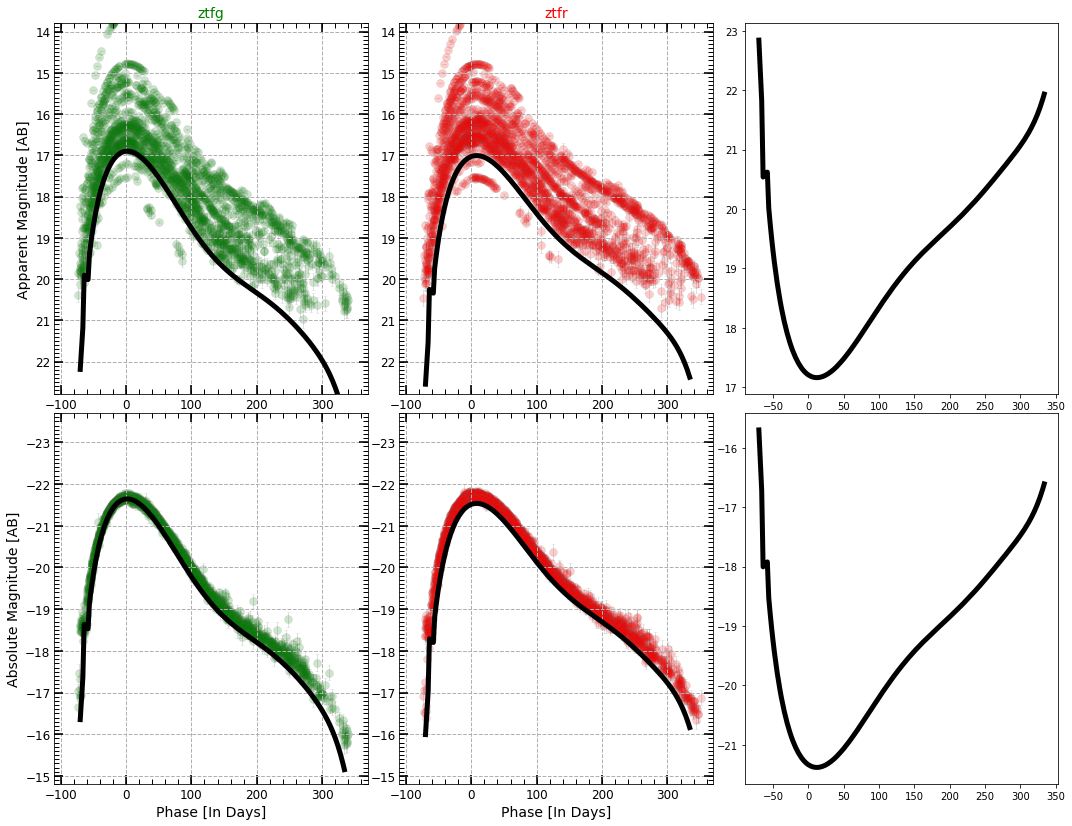

In [9]:
# ------------------------------------------------------------------------------------------------------------------- #
# Plot the Combine Results of the Simulated Light Curves
# ------------------------------------------------------------------------------------------------------------------- #

def z_to_distmod(z):
    distance = Planck15.luminosity_distance(z).value
    return 5 * np.log10(distance * 1e6) - 5


def set_plotparams(ax_obj):
    ax_obj.grid(True, which='major', ls='--', lw=1)
    ax_obj.xaxis.set_ticks_position('both')
    ax_obj.yaxis.set_ticks_position('both')
    ax_obj.yaxis.set_major_locator(MultipleLocator(1))
    ax_obj.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax_obj.xaxis.set_major_locator(MultipleLocator(100))
    ax_obj.xaxis.set_minor_locator(MultipleLocator(20))
    ax_obj.tick_params(axis='both', which='major', direction='in', width=1.6, length=9, labelsize=12)
    ax_obj.tick_params(axis='both', which='minor', direction='in', width=1.0, length=5, labelsize=12)


def plot_lcs(ax, df, lc, band):
    if band == 'ztfg':
        index = 0
        color = 'g'
    elif band == 'ztfr':
        index = 1
        color = 'r'
    elif band == 'desi':
        index =  2
        color = 'blue'

    ax_obj1 = ax[0][index]
    ax_obj2 = ax[1][index]

    zlc = data['meta']['z'][lc]
    distlc = Planck15.luminosity_distance(zlc).value
    distmag = 5 * np.log10(distlc * 1e6) - 5
    corr = distmag + data['meta']['mwebv_sfd98'][lc] * dict_rlambda[band]
    
    ax_obj1.errorbar(df['time'] - data['meta']['t0'][lc], df['mag'], yerr=df['magerr'], ms=8, alpha=0.2,
                    color='dimgrey', markerfacecolor=color, markeredgewidth=0.5, marker='o', ls='', 
                     capthick=1, elinewidth=1, capsize=2, zorder=1, label='_nolegend_')
    ax_obj2.errorbar(df['time'] - data['meta']['t0'][lc], df['mag'] - corr, yerr=df['magerr'], ms=8, 
                     alpha=0.2, color='dimgrey', marker='o', markerfacecolor=color, markeredgewidth=0.5, 
                     ls='', capthick=1, elinewidth=1, capsize=2, zorder=1, label='_nolegend_')
    
    set_plotparams(ax_obj1)
    set_plotparams(ax_obj2)
    ax_obj1.set_ylim(22.8, 13.8)
    ax_obj2.set_ylim(-14.8, -23.7)
    ax_obj1.set_xlim(-110, 370)
    ax_obj2.set_xlim(-110, 370)
    ax_obj1.set_title(band, color=color, fontsize=14)
    ax_obj2.set_xlabel('Phase [In Days]', fontsize=14)
    

fig, ax = plt.subplots(2, 3, figsize=(18, 14))

for lc in range(len(data['lcs'])):
    lc_df = pd.DataFrame(data=data['lcs'][lc], columns=data['lcs'][0].dtype.names)
    lc_df['mag'] = -2.5 * np.log10(lc_df['flux']) + lc_df['zp']
    lc_df['magerr'] = -(2.5 / np.log(10)) * (lc_df['fluxerr'] / lc_df['flux'])
    lc_df['snr'] = lc_df['flux'] / lc_df['fluxerr']
    lc_df = lc_df[lc_df['snr'] >= 5]
    
    for band, df in lc_df.groupby('band'):
        plot_lcs(ax, df, lc, band)

ptf12 = pd.read_csv(template_file, sep='\s+', comment='#')
dist_mag = z_to_distmod(0.107)

ax[0][0].plot(ptf12['Phase'], ptf12['M_g'] + dist_mag, marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')
ax[0][1].plot(ptf12['Phase'], ptf12['M_r'] + dist_mag, marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')
ax[0][2].plot(ptf12['Phase'], ptf12['M_i'] + dist_mag, marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')
ax[1][0].plot(ptf12['Phase'], ptf12['M_g'], marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')
ax[1][1].plot(ptf12['Phase'], ptf12['M_r'], marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')
ax[1][2].plot(ptf12['Phase'], ptf12['M_i'], marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')

ax[0][0].set_ylabel('Apparent Magnitude [AB]', fontsize=14)
ax[1][0].set_ylabel('Absolute Magnitude [AB]', fontsize=14)

fig.subplots_adjust(hspace=0.05, wspace=0.10)
fig.savefig('PLOT_LCS_PTF12Observed', format='pdf', dpi=2000, bbox_inches='tight')

plt.show()
plt.close(fig)
# ------------------------------------------------------------------------------------------------------------------- #

You can inspect the lightcurves manually. This example should return the lightcurve with the most points with S/N > 5.

In [10]:
# def set_plotparams(ax_obj):
#     ax_obj.grid(True, which='major', ls='--', lw=1)
#     ax_obj.xaxis.set_ticks_position('both')
#     ax_obj.yaxis.set_ticks_position('both')
#     ax_obj.yaxis.set_major_locator(MultipleLocator(1))
#     ax_obj.yaxis.set_minor_locator(MultipleLocator(0.1))
#     ax_obj.xaxis.set_major_locator(MultipleLocator(100))
#     ax_obj.xaxis.set_minor_locator(MultipleLocator(20))
#     ax_obj.tick_params(axis='both', which='major', direction='in', width=1.6, length=9, labelsize=12)
#     ax_obj.tick_params(axis='both', which='minor', direction='in', width=1.0, length=5, labelsize=12)


# def plot_lc(ax, df, lc, band):
#     if band == 'ztfg':
#         index = 0
#         color = 'g'
#     elif band == 'ztfr':
#         index = 1
#         color = 'r'
#     elif band == 'desi':
#         index =  2
#         color = 'orange'

#     ax_obj = ax[lc][index]
#     ax_obj.errorbar(df['time'] - data['meta']['t0'][lc], df['mag'], yerr=df['magerr'], color=color, 
#                     marker='*', capthick=1, elinewidth=1, capsize=2, label='_nolegend_')

#     set_plotparams(ax_obj)
#     ax_obj.set_ylim(23.5, 12.5)
#     ax_obj.set_xlim(-110, 370)
# #     ax_obj.legend(fontsize=16, loc=1)
#     ax_obj.set_title(band, color=color, fontsize=8)
#     ax_obj.set_ylim(df['mag'].max() + 1, df['mag'].min() - 1)
#     ax_obj.set_ylabel('Apparent Magnitude [AB]', fontsize=8)
#     ax_obj.set_xlabel('Phase [In Days]', fontsize=8)


# def plot_lcs(ax, df, lc, band):
#     if band == 'ztfg':
#         index = 0
#         color = 'g'
#     elif band == 'ztfr':
#         index = 1
#         color = 'r'
#     elif band == 'desi':
#         index =  2
#         color = 'blue'

#     ax_obj1 = ax[0][index]
#     ax_obj2 = ax[1][index]

#     zlc = data['meta']['z'][lc]
#     distlc = Planck15.luminosity_distance(zlc).value
#     distmag_lc = 5 * np.log10(distlc * 1e6) - 5
#     corr = distmag_lc + data['meta']['mwebv_sfd98'][lc] * dict_rlambda[band]
    
#     ax_obj1.errorbar(df['time'] - data['meta']['t0'][lc], df['mag'], yerr=df['magerr'], ms=8, alpha=0.2,
#                     color='dimgrey', markerfacecolor=color, markeredgewidth=0.5, marker='o', ls='', 
#                      capthick=1, elinewidth=1, capsize=2, zorder=1, label='_nolegend_')
#     ax_obj2.errorbar(df['time'] - data['meta']['t0'][lc], df['mag'] - corr, yerr=df['magerr'], ms=8, 
#                      alpha=0.2, color='dimgrey', marker='o', markerfacecolor=color, markeredgewidth=0.5, 
#                      ls='', capthick=1, elinewidth=1, capsize=2, zorder=1, label='_nolegend_')
    
#     set_plotparams(ax_obj1)
#     set_plotparams(ax_obj2)
#     ax_obj1.set_ylim(23.5, 12.5)
#     ax_obj2.set_ylim(-14.2, -22.3)
#     ax_obj1.set_xlim(-110, 370)
#     ax_obj2.set_xlim(-110, 370)
#     ax_obj1.set_title(band, color=color, fontsize=14)
#     ax_obj2.set_xlabel('Phase [In Days]', fontsize=14)
    

# fig, ax = plt.subplots(len(data['lcs']), 3, figsize=(12, len(data['lcs']) * 4))
# fig2, ax2 = plt.subplots(2, 3, figsize=(18, 14))

# for lc in range(len(data['lcs'])):
#     lc_df = pd.DataFrame(data=data['lcs'][lc], columns=data['lcs'][0].dtype.names)
#     lc_df['mag'] = -2.5 * np.log10(lc_df['flux']) + lc_df['zp']
#     lc_df['magerr'] = -2.5 * (lc_df['fluxerr'] / lc_df['flux'])
    
#     for band, df in lc_df.groupby('band'):
#         plot_lc(ax, df, lc, band)
#         plot_lcs(ax2, df, lc, band)

# ptf12 = pd.read_csv(template_file, sep='\s+', comment='#')
# ax2[0][0].plot(ptf12['Phase'], ptf12['M_g'] + dist_mag, marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')
# ax2[0][1].plot(ptf12['Phase'], ptf12['M_r'] + dist_mag, marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')
# ax2[0][2].plot(ptf12['Phase'], ptf12['M_i'] + dist_mag, marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')

# ax2[1][0].plot(ptf12['Phase'], ptf12['M_g'], marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')
# ax2[1][1].plot(ptf12['Phase'], ptf12['M_r'], marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')
# ax2[1][2].plot(ptf12['Phase'], ptf12['M_i'], marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')

# ax2[0][0].set_ylabel('Apparent Magnitude [AB]', fontsize=14)
# ax2[1][0].set_ylabel('Absolute Magnitude [AB]', fontsize=14)

# fig.savefig('PLOT_LCS.pdf', format='pdf', dpi=2000, bbox_inches='tight')
# fig2.subplots_adjust(hspace=0.05, wspace=0.10)
# fig2.savefig('PLOT_LCS_PTF12Observed.pdf', format='pdf', dpi=2000, bbox_inches='tight')

# plt.show()
# plt.close(fig2)

### Detection Phase Distribution

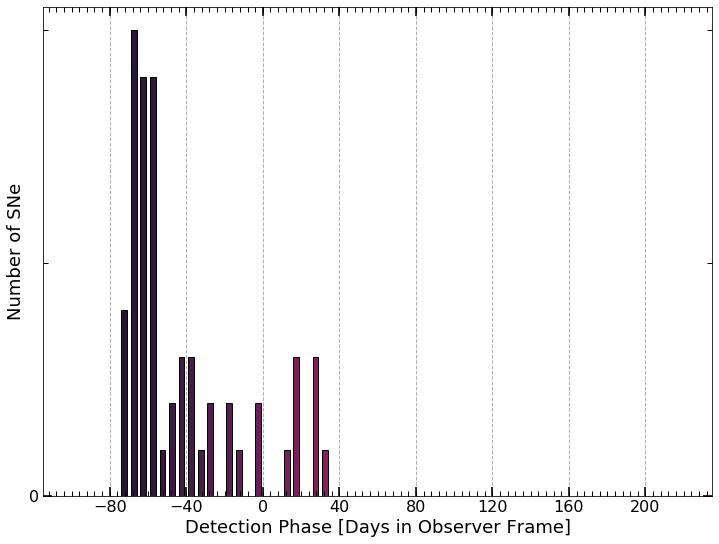

In [11]:
fig1 = plt.figure(figsize=(12, 9))
ax1 = fig1.add_subplot(111)

heights, bins = np.histogram(lcs.stats['p_det'], range=(-110, 225), bins=67)
centers = (bins[:-1] + bins[1:]) / 2

ax1.bar(centers, heights, width=3, edgecolor='k', color=sns.color_palette('rocket', int(len(bins) * 1.2)))
# ax1.hist(lcs.stats['p_det'], histtype='bar', rwidth=0.75, color='dimgrey', range=(-10, 120), bins=32)

ax1.set_xlim(-115, 235)
ax1.grid(True, which='major', ls='--', lw=1)
ax1.xaxis.set_ticks_position('both')
ax1.yaxis.set_ticks_position('both')
ax1.yaxis.set_major_locator(MultipleLocator(50))
ax1.yaxis.set_minor_locator(MultipleLocator(5))
ax1.xaxis.set_major_locator(MultipleLocator(40))
ax1.xaxis.set_minor_locator(MultipleLocator(4))
ax1.tick_params(axis='both', which='major', direction='in', width=1.6, length=9, labelsize=16)
ax1.tick_params(axis='both', which='minor', direction='in', width=1.0, length=5, labelsize=16)

ax1.set_xlabel('Detection Phase [Days in Observer Frame]', fontsize=18)
ax1.set_ylabel('Number of SNe', fontsize=18)

fig1.savefig('PLOT_SLSNDetectionPhaseDistribution.pdf', format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig1)

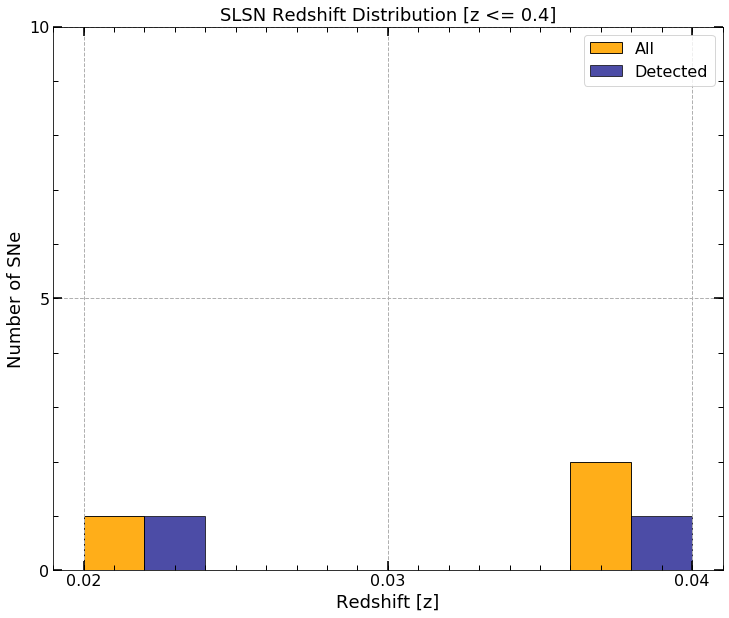

In [12]:
fig2 = plt.figure(figsize=(12, 10))
ax2 = fig2.add_subplot(111)

zhsfull, zbinsfull = np.histogram(lcs.meta_full['z'], range=(0.02, 0.04), bins=5)
zcentersfull = (zbinsfull[:-1] + zbinsfull[1:]) / 2
zhs, zbins = np.histogram(lcs.meta['z'], range=(0.02, 0.04), bins=5)
zcenters = (zbins[:-1] + zbins[1:]) / 2

ax2.bar(zcentersfull - 0.001, zhsfull, width=0.002, alpha=0.9, edgecolor='k', color='orange', label='All')
ax2.bar(zcenters + 0.001, zhs, width=0.002, alpha=0.7, edgecolor='k', color='navy', label='Detected')

# ax2.hist(lcs.meta_full['z'], lw=2, ls='-', histtype='step', color='orangered', range=(0,0.05), bins=25, label='All')
# ax2.hist(lcs.meta['z'], lw=2, ls='-', histtype='step', color='navy', range=(0, 0.05), bins=25, label='Detected')

ax2.set_ylim(0, 10)
ax2.legend(fontsize=16, loc=1)
ax2.grid(True, which='major', ls='--', lw=1)
ax2.xaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')
ax2.yaxis.set_major_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(MultipleLocator(1))
ax2.xaxis.set_major_locator(MultipleLocator(0.01))
ax2.xaxis.set_minor_locator(MultipleLocator(0.001))
ax2.tick_params(axis='both', which='major', direction='in', width=1.6, length=9, labelsize=16)
ax2.tick_params(axis='both', which='minor', direction='in', width=1.0, length=5, labelsize=16)

# ax2.set_xticklabels(['' if float(label) < 0 else round(label, 1) for label in ax2.get_xticks()])

ax2.set_xlabel('Redshift [z]', fontsize=18)
ax2.set_ylabel('Number of SNe', fontsize=18)
ax2.set_title('SLSN Redshift Distribution [z <= 0.4]', fontsize=18)

# axins = ax2.inset_axes([0.07, 0.43, 0.53, 0.55])
# # axins.bar(zcentersfull - 0.005, zhsfull, width=0.01, alpha=0.9, color='orangered', label='All')
# axins.bar(zcenters + 0.005, zhs, width=0.01, alpha=0.9, edgecolor='k', color='navy', label='Detected')

# axins.set_xlim(-0.05, 0.45)
# axins.set_ylim(0, 38)

# axins.grid(True, which='major', ls='--', lw=1)
# axins.xaxis.set_ticks_position('both')
# axins.yaxis.set_ticks_position('both')
# axins.yaxis.set_major_locator(MultipleLocator(10))
# axins.yaxis.set_minor_locator(MultipleLocator(1))
# axins.xaxis.set_major_locator(MultipleLocator(0.1))
# axins.xaxis.set_minor_locator(MultipleLocator(0.01))
# axins.tick_params(axis='both', which='major', direction='in', width=1.6, length=9, labelsize=16)
# axins.tick_params(axis='both', which='minor', direction='in', width=1.0, length=5, labelsize=16)
# ax2.indicate_inset_zoom(axins)

fig2.savefig('PLOT_SLSNRedshiftDistribution.pdf', format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig2)


In [13]:
# # ------------------------------------------------------------------------------------------------------------------- #
# # Test Code To Find The Faulty ZTF Data
# # ------------------------------------------------------------------------------------------------------------------- #
# raw_df = pd.read_pickle(os.path.join(DIR_DATA, survey_file))
# idx_range = raw_df.index.values
# val_range = np.array_split(idx_range, 1000)

# for val in val_range:
#     try:
#         raw_df = mod_df(pd.read_pickle(os.path.join(DIR_DATA, survey_file)).iloc[val])
#         plan = simsurvey.SurveyPlan(time=raw_df['jd'], band=raw_df['filterid'], obs_field=raw_df['fieldid'], 
#                             skynoise=raw_df['skynoise'], obs_ccd=raw_df['chid'], ccds=ccds, comment=raw_df['progid'], 
#                             fields={k: v for k, v in fields.items() if k in ['ra', 'dec', 'field_id']})
#     except IndexError:
#         print (val)
#         import sys
#         sys.exit(1)
#     else:
#         continue
    
# # ------------------------------------------------------------------------------------------------------------------- #